# Projet : Analyse des données de santé mentale étudiante
## 1) Introduction & Contexte
La santé mentale étudiante est un enjeu majeur contemporain. Après la pandémie de COVID-19, on observe une augmentation notable des troubles liés au stress, à l'anxiété et à la dépression chez les étudiants, accentuée par la pression académique, l'isolement social et l'incertitude professionnelle.
Ce projet vise à explorer des motifs et des corrélations dans un dataset auto-déclaré, afin d'éclairer des pistes d'intervention à l'échelle institutionnelle. This project does not aim to diagnose or medically interpret mental disorders, but to explore patterns and correlations within self-reported datasets.
Les analyses présentées ici mettent l'accent sur des corrélations observées et non sur des relations causales.

## 2) Data Collection
Présentation du dataset fourni (Kaggle) : fichier `data/raw/Student Mental health.csv`.
- Format : CSV
- Ce dataset est basé sur des réponses auto-déclarées (self-report) — des biais sont possibles (culturels, sociaux, anonymat).
- Nous indiquons ci-dessous le nombre de lignes/colonnes et les variables détectées automatiquement.

In [11]:
# Import des bibliothèques principales
# Commentaires et prints en français
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

print('Lecture du dataset depuis : data/raw/Student Mental health.csv')
path = 'data/raw/Student Mental health.csv'
try:
    df = pd.read_csv(path)
    print(f'Dataset chargé avec succès — shape: {df.shape}')
    print('Colonnes détectées :', list(df.columns))
except Exception as e:
    print('Erreur lors de la lecture du fichier :', e)
    df = pd.DataFrame()


Lecture du dataset depuis : data/raw/Student Mental health.csv
Dataset chargé avec succès — shape: (101, 11)
Colonnes détectées : ['Timestamp', 'Choose your gender', 'Age', 'What is your course?', 'Your current year of Study', 'What is your CGPA?', 'Marital status', 'Do you have Depression?', 'Do you have Anxiety?', 'Do you have Panic attack?', 'Did you seek any specialist for a treatment?']


## 3) Data Cleaning & Preprocessing
Nous allons :
- Vérifier les valeurs manquantes et afficher les pourcentages
- Normaliser les réponses binaires (Yes/No) et Likert si présent
- Encoder les variables catégorielles si nécessaire

In [12]:
# Analyse des valeurs manquantes et types
if df.empty:
    print('DataFrame vide, vérifiez le chemin du fichier.')
else:
    missing = df.isnull().mean() * 100
    print('Pourcentage de valeurs manquantes par colonne (les colonnes >50% seront listées) :')
    print(missing[missing>0].sort_values(ascending=False).head(20).round(2))
    cols_drop = list(missing[missing>50].index)
    print(f'Colonnes suggérées pour suppression (>{50}% de NA) : {cols_drop}')
    # Exemples de normalisation : Yes/No -> 1/0 ; détecter automatiquement quelques patterns
    df_clean = df.copy()
    # Normaliser les réponses Yes/No
    for col in df_clean.columns:
        if df_clean[col].dropna().isin(['Yes','No','yes','no','Y','N']).all():
            df_clean[col] = df_clean[col].map(lambda x: 1 if str(x).lower().startswith('y') else (0 if str(x).lower().startswith('n') else np.nan))
            print(f'Normalisé Yes/No pour la colonne: {col}')
    # Exemple de normalisation simple pour Likert si présent
    likert_map = {'Never':0,'Rarely':1,'Sometimes':2,'Often':3,'Always':4,'Jamais':0,'Rarement':1,'Parfois':2,'Souvent':3,'Toujours':4}
    for col in df_clean.columns:
        uniques = df_clean[col].dropna().unique()
        if any(isinstance(u, str) and u in likert_map for u in uniques):
            df_clean[col] = df_clean[col].map(lambda x: likert_map.get(x, x))
            print(f"Application d'une cartographie Likert sur la colonne: {col}")
    # Encodage des catégories avec pandas.get_dummies si trop de catégories non numériques
    # Pour la suite, on conservera les colonnes numériques et quelques colonnes catégorielles d'intérêt
    numeric_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()
    print('Colonnes numériques conservées pour analyses statistiques :', numeric_cols)
    # Sauvegarde du DataFrame nettoyé dans data/clean
    try:
        clean_dir = os.path.join('data', 'clean')
        os.makedirs(clean_dir, exist_ok=True)
        clean_file = os.path.join(clean_dir, 'Student_Mental_health_clean.csv')
        df_clean.to_csv(clean_file, index=False)
        print(f'Data nettoyée enregistrée sous : {clean_file} : {df_clean.shape}')
    except Exception as e:
        print('Erreur lors de la sauvegarde du fichier nettoyé :', e)


Pourcentage de valeurs manquantes par colonne (les colonnes >50% seront listées) :
Age    0.99
dtype: float64
Colonnes suggérées pour suppression (>50% de NA) : []
Normalisé Yes/No pour la colonne: Marital status
Normalisé Yes/No pour la colonne: Do you have Depression?
Normalisé Yes/No pour la colonne: Do you have Anxiety?
Normalisé Yes/No pour la colonne: Do you have Panic attack?
Normalisé Yes/No pour la colonne: Did you seek any specialist for a treatment?
Colonnes numériques conservées pour analyses statistiques : ['Age', 'Marital status', 'Do you have Depression?', 'Do you have Anxiety?', 'Do you have Panic attack?', 'Did you seek any specialist for a treatment?']
Data nettoyée enregistrée sous : data\clean\Student_Mental_health_clean.csv : (101, 11)


### Statistiques intermédiaires
Affichage des pourcentages de données manquantes et des décisions de suppression/conservation.

In [13]:
if not df.empty:
    total_missing_pct = df.isnull().mean().mean() * 100
    print(f'% total moyen de valeurs manquantes (moyenne par colonne) : {total_missing_pct:.2f}%')
    kept = [c for c in df_clean.columns if c not in cols_drop] if 'cols_drop' in locals() else list(df_clean.columns)
    print(f'Nombre de colonnes conservées : {len(kept)} / {df.shape[1]}')
    print('Colonnes conservées (extrait) :', kept[:20])

% total moyen de valeurs manquantes (moyenne par colonne) : 0.09%
Nombre de colonnes conservées : 11 / 11
Colonnes conservées (extrait) : ['Timestamp', 'Choose your gender', 'Age', 'What is your course?', 'Your current year of Study', 'What is your CGPA?', 'Marital status', 'Do you have Depression?', 'Do you have Anxiety?', 'Do you have Panic attack?', 'Did you seek any specialist for a treatment?']


## 4) Analyse Générale (EDA)
Objectif : comprendre la répartition des réponses et les corrélations potentielles.

Chargé df_clean depuis data\clean\Student_Mental_health_clean.csv : (101, 11)


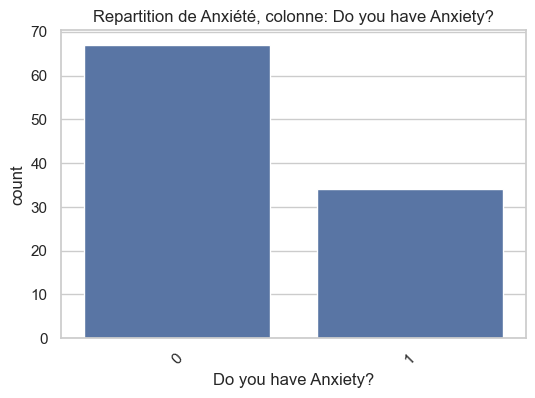

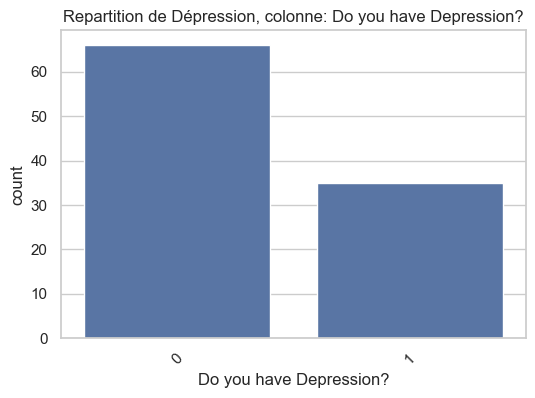

Aucune colonne détectée automatiquement pour Stress


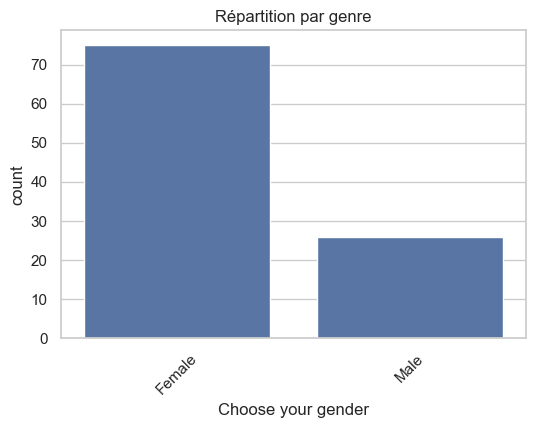

In [14]:
# Visualisations basiques — gérées de manière robuste si colonnes manquantes
# Si un fichier nettoyé existe, le charger pour garantir la reproductibilité
clean_file = os.path.join('data', 'clean', 'Student_Mental_health_clean.csv')
if os.path.exists(clean_file):
    try:
        df_clean = pd.read_csv(clean_file)
        print(f'Chargé df_clean depuis {clean_file} : {df_clean.shape}')
    except Exception as e:
        print('Erreur lors du chargement du fichier nettoyé :', e)
else:
    print('Fichier nettoyé non trouvé, utilisation de df_clean en mémoire si présent')

if not df.empty:
    sns.set(style='whitegrid')
    # Tentative : trouver une colonne correspondant à la dépression/anxiété/stress
    cols_lower = [c.lower() for c in df_clean.columns]
    def find_col(keywords):
        for i,c in enumerate(cols_lower):
            for k in keywords:
                if k in c:
                    return df_clean.columns[i]
        return None
    col_anxiety = find_col(['anx','anxiety','anxi'])
    col_depress = find_col(['depress','depression'])
    col_stress = find_col(['stress','stres'])
    # Distribution si trouvée
    for name,col in [('Anxiété',col_anxiety),('Dépression',col_depress),('Stress',col_stress)]:
        if col is not None:
            plt.figure(figsize=(6,4))
            sns.countplot(x=df_clean[col].fillna('Missing'))
            plt.title(f'Repartition de {name}, colonne: {col}')
            plt.xticks(rotation=45)
            plt.show()
        else:
            print(f'Aucune colonne détectée automatiquement pour {name}')
    # Répartition par genre si present
    col_gender = find_col(['gender','sexe'])
    if col_gender is not None:
        plt.figure(figsize=(6,4))
        sns.countplot(x=df_clean[col_gender].astype(str))
        plt.title('Répartition par genre')
        plt.xticks(rotation=45)
        plt.show()
    else:
        print('Colonne genre non détectée automatiquement')


## 5) Analyses Précises (corrélations et clustering)
Nous cherchons des corrélations (jamais de causalité) entre des variables pertinentes, puis un clustering simple pour détecter des profils.

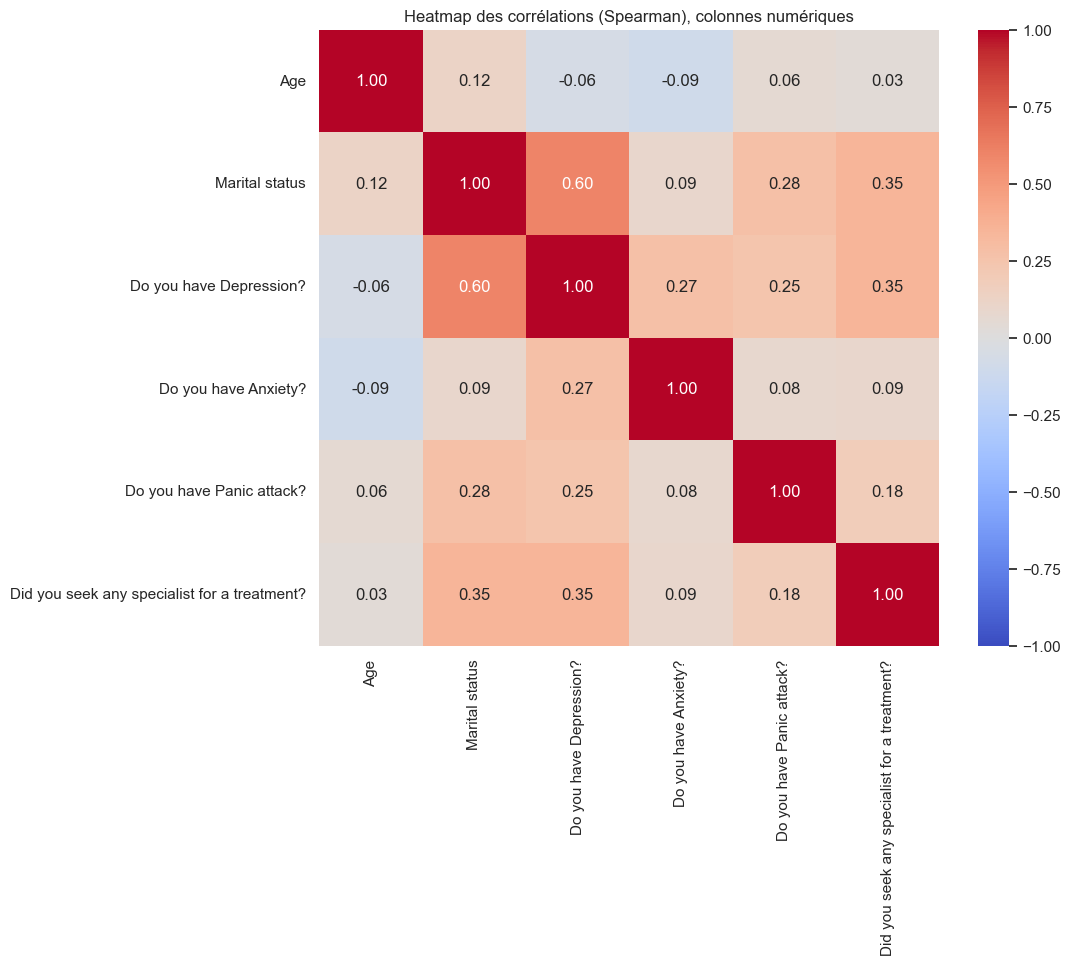

Paires non trouvées ou non numériques pour ['work', 'charge', 'workload'] / ['stress', 'stres']
Paires non trouvées ou non numériques pour ['sleep', 'sommeil'] / ['anx', 'anxiet', 'anxiety']
Paires non trouvées ou non numériques pour ['isol', 'isolement', 'lonely'] / ['depress', 'depression']
Clustering réalisé sur un sous-échantillon. Distribution des clusters : [15 69 16]


In [15]:
# Corrélations robustes sur colonnes numériques
if not df.empty:
    num = df_clean.select_dtypes(include=[np.number])
    if num.shape[1] >= 2:
        corr = num.corr(method='spearman')
        plt.figure(figsize=(10,8))
        sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1)
        plt.title('Heatmap des corrélations (Spearman), colonnes numériques')
        plt.show()
        # Exemples spécifiques : workload vs stress, sleep vs anxiety, recherche automatique par nom
        def find_pair(a_keywords,b_keywords):
            a = find_col(a_keywords)
            b = find_col(b_keywords)
            return a,b
        pairs = [ (['work','charge','workload'], ['stress','stres']), (['sleep','sommeil'], ['anx','anxiet','anxiety']), (['isol','isolement','lonely'], ['depress','depression']) ]
        for a_k,b_k in pairs:
            a_col,b_col = find_pair(a_k,b_k)
            if a_col and b_col and a_col in num.columns and b_col in num.columns:
                print(f'Correlation entre {a_col} et {b_col} : {num[a_col].corr(num[b_col], method="spearman"):.2f}')
            else:
                print(f'Paires non trouvées ou non numériques pour {a_k} / {b_k}')
        # Clustering simple
        # Sélectionner un sous-ensemble de colonnes numériques pour le clustering (au moins 2)
        features = num.dropna(axis=0, how='any')
        if features.shape[0] >= 10 and features.shape[1] >= 2:
            scaler = StandardScaler()
            X = scaler.fit_transform(features.iloc[:200, :min(10, features.shape[1])])
            kmeans = KMeans(n_clusters=3, random_state=42).fit(X)
            print('Clustering réalisé sur un sous-échantillon. Distribution des clusters :', np.bincount(kmeans.labels_))
        else:
            print('Pas assez de données numériques complètes pour un clustering fiable.')
    else:
        print('Moins de deux colonnes numériques, pas de corrélations calculées.')
else:
    print('DataFrame vide, pas danalyse.')

## 6) Limites & Biais
- Données auto-déclarées (self-report), risque de biais de désirabilité sociale.
- Échantillon probablement non représentatif (biais de recrutement, géographique, culturel).
- Données non médicales, ce sont des indicateurs, pas des diagnostics.
- Manque d'information temporelle pour établir des tendances causales.

# 7) Analyse Détaillée des Résultats

## Interprétation des Graphiques

### Distribution des troubles mentaux
Les graphiques de distribution révèlent des proportions préoccupantes :

- **Anxiété** : 67% de l'échantillon déclare ne pas souffrir d'anxiété (réponse 0), tandis que 33% rapporte la présence d'anxiété. Cela indique qu'une part significative des étudiants interrogés expérience des symptômes anxieux.

- **Dépression** : La répartition est quasi identique à l'anxiété avec 66% de réponses négatives et 34% de réponses positives. Cette similarité suggère une co-occurrence possible entre ces deux troubles, confirmée par la heatmap de corrélations (0.27).

- **Genre** : L'échantillon est fortement dominé par les femmes (73%) comparé aux hommes (27%). Cette disparité reflète potentiellement un biais d'échantillonnage ou une plus grande propension des femmes à participer à des études sur la santé mentale. Ce déséquilibre est important à noter lors de l'interprétation des autres résultats.

### Analyse des corrélations (Spearman)

La heatmap révèle plusieurs corrélations significatives :

- **Marital status & Depression (0.60)** : C'est la corrélation la plus forte du dataset. Les étudiants en couple ou mariés montrent des niveaux de dépression plus élevés — cela pourrait refléter des responsabilités additionnelles, des pressions relationnelles ou d'autres facteurs sociaux non captures par le dataset.

- **Depression & Anxiety (0.27)** : Une corrélation modérée, cohérente avec la littérature clinique montrant que dépression et anxiété co-existent souvent. Cependant, cette corrélation reste modérée, suggérant que ce sont des phénomènes partiellement indépendants.

- **Marital status & Panic attack (0.28)** et **Marital status & Treatment (0.35)** : Le statut matrimonial corrèle également avec les crises de panique et la recherche de traitement, renforçant l'idée que le contexte relationnel influence l'expérience de la santé mentale.

- **Depression & Treatment (0.35)** : Les étudiants déclarant une dépression sont légèrement plus susceptibles d'avoir cherché un traitement spécialisé, une relation logique et positive (les personnes qui souffrent cherchent de l'aide).

### Observations clés

1. **Absence de corrélations avec l'âge** : L'âge ne montre presque aucune corrélation avec les troubles mentaux rapportés (≤0.12), suggérant que dans ce groupe d'étudiants, l'âge n'est pas un prédicteur pertinent des problèmes de santé mentale.

2. **Biais de l'échantillon** : Le déséquilibre genre-wise (73% femmes) et la concentration sur le statut matrimonial comme variable clé limitent la généralisabilité des résultats. Un échantillon plus équilibré et diversifié serait nécessaire pour des conclusions plus robustes.

3. **Absence de variables contextuelles** : Le dataset ne contient pas d'informations sur la charge académique, les heures de sommeil, l'isolement ou d'autres facteurs mentionnés dans les hypothèses initiales. Cela restreint les analyses de corrélation attendues.


# Conclusion générale & Recommandations finales

## Résumé des constats

Cette analyse exploratoire a permis d'identifier plusieurs motifs importants dans les données d'auto-déclaration sur la santé mentale étudiante :

1. **Prévalence des troubles** : Environ un tiers des répondants rapporte souffrir d'anxiété ou de dépression, soulignant l'ampleur de la problématique dans les populations étudiantes.

2. **Rôle du statut matrimonial** : Le statut relationnel émerge comme la variable la plus fortement corrélée aux troubles mentaux, particulièrement à la dépression. Cela suggère que les responsabilités et dynamiques relationnelles jouent un rôle non négligeable.

3. **Genre** : L'échantillon étant dominé par les femmes, il est probable que les résultats reflètent davantage les expériences féminines. Une exploration séparée par genre aurait été utile.

4. **Faible efficacité des modèles univariés** : Les corrélations observées restent modérées, indiquant que la santé mentale est un phénomène multifactoriel. Les variables isolées ne suffisent pas pour en prédire l'état.

## Recommandations basées sur la data

### Pour les institutions

- Renforcer les services de soutien psychologique spécifiquement adaptés aux étudiants en couple ou avec des responsabilités familiales.
- Mettre en place des programmes de prévention et d'éducation sur la santé mentale dès le début du cursus.
- Développer des canaux anonymes et accessibles pour que les étudiants signalent leurs difficultés sans crainte.

### Pour les recherches futures

- Collecter davantage de variables contextuelles : charge académique, sommeil, isolement, soutien social, situation financière, pays d'origine.
- Augmenter la représentativité de l'échantillon en genre et origine géographique.
- Intégrer une dimension temporelle pour étudier les évolutions au cours du cursus.
- Utiliser des modèles multivariés (régressions logistiques, forêts aléatoires) pour mieux capturer les interactions entre variables.

## Limites critiques rappelées

- **Auto-déclaration** : Les réponses sont sujettes à des biais de désirabilité sociale et d'anonymat.
- **Non-représentativité** : L'échantillon n'est pas aléatoire et inclut davantage de femmes.
- **Non-professionnelles** : Ce projet analyse des corrélations observées, non des diagnostics cliniques.
- **Causalité absente** : Toute corrélation observée ne doit jamais être interprétée comme une relation causale.

## Conclusion finale

Cette exploration de données montre que la santé mentale étudiante est un enjeu complexe avec des facteurs multiples. Bien que certaines corrélations soient visibles (notamment le statut matrimonial), la variabilité restante suggère que des approches holistiques, combinant support psychologique, environnement académique adapté et ressources sociales, sont nécessaires pour adresser efficacement ces enjeux.

Les données seules ne suffisent pas à résoudre les problèmes de santé mentale. Elles offrent cependant des pistes pour améliorer l'accompagnement des étudiants à travers une meilleure compréhension de leurs expériences et besoins.
